In [5]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import pywt
import cv2
import os
import logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [6]:
class Import_Frcnn():
	def __init__(self, location):
		self.graph_frcnn = tf.Graph()
		self.sess = tf.compat.v1.Session(graph=self.graph_frcnn)
		with self.graph_frcnn.as_default():
			self.od_graph_def = tf.compat.v1.GraphDef()	
			with tf.io.gfile.GFile(location, 'rb') as fid:
				serialized_graph = fid.read()
				self.od_graph_def.ParseFromString(serialized_graph)
				tf.import_graph_def(self.od_graph_def, name='')
		try:
			self.image_tensor = self.graph_frcnn.get_tensor_by_name('image_tensor:0')
			self.detection_boxes = self.graph_frcnn.get_tensor_by_name('detection_boxes:0')
			self.detection_scores = self.graph_frcnn.get_tensor_by_name('detection_scores:0')
			self.detection_classes = self.graph_frcnn.get_tensor_by_name('detection_classes:0')
			self.num_detections = self.graph_frcnn.get_tensor_by_name('num_detections:0')
			print("Model FRCNN ready")
		except:
			logging.warning("FRCNN Model loading Error...")

	def run(self, frame):
		image_np = np.expand_dims(frame, axis = 0)
		return self.sess.run([self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],feed_dict={self.image_tensor: image_np})

class Import_MTL():
	def __init__(self, location):
		self.graph_mtl = load_graph(location)
		self.sess = tf.compat.v1.Session(graph = self.graph_mtl)
		self.y_pred_quality = self.graph_mtl.get_tensor_by_name("prefix/y_pred_quality:0")
		self.y_pred_ripeness = self.graph_mtl.get_tensor_by_name("prefix/y_pred_ripeness:0")
		self.x = self.graph_mtl.get_tensor_by_name("prefix/x:0") 
		print("Model MTL ready")

	def run(self, frame):
		image_rgb = cv2.resize(frame, (50,50))
		image_rgb = np.expand_dims(image_rgb, axis = 0)
		return self.sess.run([self.y_pred_quality, self.y_pred_ripeness], feed_dict={self.x: image_rgb})

def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the unserialized graph_def
    with tf.io.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

def normalize_size(x):
    #Values obtained from train.py output
    mean = np.asarray([[76.06636364, 119.57220779]])
    std = np.asarray([[5.95719927, 8.19216614]])
    x_normalized = (x - mean) / std
    return x_normalized

def convert_sizes(size):
	size = int(size)
	if size >= 400:
		return "Large"
	elif size <= 399 and size >= 200:
		return "medium"
	elif size < 199:
		return "small"

def predict_size(x_input):
    # input: [width, length, thickness]
    # output: [size, size_classification]
    x_input = normalize_size(x_input)
    graph = load_graph("frozen_models/LR_frozen_model.pb")

    #input and output node
    x = graph.get_tensor_by_name('prefix/x:0')
    y = graph.get_tensor_by_name('prefix/Wx_b/Add:0')

    with tf.compat.v1.Session(graph = graph) as sess:
        y_output = sess.run(y, feed_dict={x: x_input})

    return y_output, convert_sizes(y_output)


In [7]:
def w2d(imArray, mode='haar', level=1):
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

class ImageProcess:
	def __init__(self,img):
		self.nor_img = img
		self.img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	def proceess_images(self):
		ret,binary = cv2.threshold(self.img,160,255,cv2.THRESH_BINARY)# 160 - threshold, 255 - value to assign, THRESH_BINARY_INV - Inverse binary
		kernel = np.ones((5,5),np.float32)/9  		#averaging filter
		dst = cv2.filter2D(binary,-1,kernel)		# -1 : depth of the destination image
		kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
		erosion = cv2.erode(dst,kernel2,iterations = 1)
		dilation = cv2.dilate(erosion,kernel2,iterations = 1)
		edges = cv2.Canny(dilation,100,200)			#edge detection
		contours,hierarchy = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)	# Size detection
		total_ar=0
		for cnt in contours:
			x,y,w,h = cv2.boundingRect(cnt)
			aspect_ratio = float(w)/h
			if(aspect_ratio<1):
				aspect_ratio=1/aspect_ratio
			#print( round(aspect_ratio,2),self.get_classificaton(aspect_ratio))
			total_ar+=aspect_ratio
		avg_ar=total_ar/len(contours)
		#print ("Average Aspect Ratio=",round(avg_ar,2),self.get_classificaton(avg_ar))
		wavelet = w2d(self.nor_img)
		self.img_list = [self.img , binary , dst, erosion ,dilation , edges, wavelet]
		self.title = ["Original image","Binary image","Filtered image","Eroded image","Dialated image","Edge detect", "wavelet"]
		return self.img_list, self.title

def plot_img(imgs_row, imgs_col ,img_list, img_title):
	#imgs_row ,imgs_col =2,3
	n = imgs_row * imgs_col
	for no in range(n):
		plt.subplot(imgs_row,imgs_col,no+1)
		plt.imshow(img_list[no],'gray')
		plt.title(img_title[no])
	plt.show()

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def get_size(image_frame, calibrated_pxm):
	#This function returns Y dimension, X dimension, Area, midx, midy, 
	gray = cv2.cvtColor(image_frame, cv2.COLOR_BGR2GRAY)
	cv2.imwrite("gray.png", gray)
	gray = cv2.GaussianBlur(gray, (7, 7), 0)
	cv2.imwrite("gaussianblur.png", gray)
	# perform edge detection, then perform a dilation + erosion to close gaps in between object edges
	canny = cv2.Canny(gray, 50, 100)
	edged = cv2.dilate(canny, None, iterations=1)
	edged = cv2.erode(edged, None, iterations=1)
	#Find contours
	(cnts,_) = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	#print(cnts,_)
	areaArray = []
	for i, c in enumerate(cnts):
		area = cv2.contourArea(c)
		areaArray.append(area)
	sorteddata = sorted(zip(areaArray,cnts), key=lambda x: x[0], reverse=True)
	c = sorteddata[0][1] 
	x,y,w,h = cv2.boundingRect(c)
	dA,dB = w,h
	X = dA / calibrated_pxm
	Y = dB / calibrated_pxm
	X = X * 25.4
	Y = Y * 25.4
	if X > Y:
		Y_ = X
		X_ = Y
	else:
		Y_ = Y
		X_ = X
	return X_, Y_

def get_box(boxes, scores, image):
	boxes = np.squeeze(boxes)
	height, width = image.shape[:2]
	box = None
	score = None
	ymin, xmin, ymax, xmax = boxes[0]
	box = [xmin * width, xmax * width, ymin * height, ymax * height]
	score = scores.item(0)
	return box, score

def draw_boxes_scores(box_array, score_array, ripe_array, quality_array, frame):
	ripeness_dict = {0: 'Green', 1: 'Semi-Ripe', 2: 'Ripe'}
	quality_dict = {0: 'Good', 1: 'Defect'}
	cv2.rectangle(frame, (int(box_array[0]), int(box_array[2])), (int(box_array[1]), int(box_array[3])),(0,255,0),3)
	#cv2.putText(frame, "Detection:  {0:.2f}".format(score_array), (10, 16), cv2.FONT_HERSHEY_TRIPLEX, 0.6, (0,0,0))
	#cv2.putText(frame, "Quality:  {}".format(quality_dict[int(np.argmax(quality_array, axis=1))]), (10, 32), cv2.FONT_HERSHEY_TRIPLEX, 0.6, (0,0,0))
	#cv2.putText(frame, "Ripeness:  {}".format(ripeness_dict[int(np.argmax(ripe_array, axis=1))]), (10, 48), cv2.FONT_HERSHEY_TRIPLEX, 0.6, (0,0,0))
	return frame, quality_dict[int(np.argmax(quality_array, axis=1))], ripeness_dict[int(np.argmax(ripe_array, axis=1))]

def create_models():
	#predict up to 3 items only
	model_mtl = Import_MTL("frozen_models/MTL_frozen_model.pb")
	model_frcnn = Import_Frcnn('frozen_models/frozen_inference_graph.pb')
	model_lr = load_graph('frozen_models/LR_frozen_model.pb')
	return model_mtl,model_frcnn,model_lr 


In [8]:
model_mtl,model_frcnn,model_lr = create_models()
HEIGHT = 256
WIDTH = 128
DIMENSION =3
def image_to_array(image):
    image=Image.fromarray(image)
    #image = Image.open(crop_img)
    image = image.resize((HEIGHT,WIDTH))
    #image = image.convert("L")
    return np.array(image)    # return values as numpy array format

def cropped_image(image): 
	(boxes, scores, classes, num) = model_frcnn.run(image)
	box_array, scores_ = get_box(boxes, scores, image)
	if scores_:
		left, right, top, bottom  = map(lambda x :int(x),box_array)
		#rec_img = cv2.rectangle(image,(left,top),(right,bottom),(255,255,0),2)
		crop = image[top:bottom, left:right]	
		return crop

Model MTL ready
Model FRCNN ready


In [9]:
def image_analysis(image):
	(boxes, scores, classes, num) = model_frcnn.run(image)
	box_array, scores_ = get_box(boxes, scores, image)
	print(box_array, scores_)
	if scores_:
		left, right, top, bottom  = map(lambda x :int(x),box_array)
		rec_img = cv2.rectangle(image,(left,top),(right,bottom),(255,255,0),2)
		crop = image[top:bottom, left:right]
		ImageProcess_obj = ImageProcess(crop)
		img_list, img_title = ImageProcess_obj.proceess_images()	
		img_list.append(rec_img)
		img_title.append("Object Detect")
		img_list.append(crop)
		img_title.append("Cropped Img")
		x, y =get_size(crop, 82)
		weight, size = predict_size([x,y])
		quality, ripeness = model_mtl.run(crop)
		img, quality_, ripeness_ = draw_boxes_scores(box_array, scores_, ripeness, quality, image)
	plot_img(3,3,img_list,img_title)
	return quality_, ripeness_, size

In [27]:
data_path1 = r"Dataset/Grading_dataset/Class_I"
data_path2 = r"Dataset/Grading_dataset/Class_II"
data_path3 = r"Dataset/Grading_dataset/Class_III"
data_path4 = r"Dataset/Grading_dataset/Class_defect"

grade1 = os.listdir(data_path1)
grade2 = os.listdir(data_path2)
grade3 = os.listdir(data_path3)
grade4 = os.listdir(data_path4)
print(len(grade1),grade1[:5])
print(len(grade2),grade2[:5])
print(len(grade3),grade3[:5])
print(len(grade4),grade4[:5])

269 ['IMG_20210703_151539.jpg', 'IMG_20210703_151605.jpg', 'IMG_20210703_151609.jpg', 'IMG_20210703_151624.jpg', 'IMG_20210703_151611.jpg']
197 ['IMG_20210703_155504.jpg', 'IMG_20210703_155515.jpg', 'IMG_20210703_155501.jpg', 'IMG_20210703_155528.jpg', 'IMG_20210703_155540.jpg']
21 ['atest_1.jpeg', 'IMG_20210703_155835.jpg', 'IMG_20210703_160038.jpg', 'IMG_20210703_160016.jpg', 'IMG_20210703_160026.jpg']
84 ['amango1.jpg', 'rotten-mango-yellow-thailand-fruit-47156776.jpg', 'rotten-exotic-fruit.jpg', 'overripe-fruitrotten-mango-isolated-on-260nw-1778574416.jpg', 'rotten-mango.jpg']


Creating the labels for grades of mango

Grade 1 => 0
Grade 2 => 1
Grade 3 => 2
Grade 4 => 3

In [28]:
g1_label = [0]*len(grade1)
g2_label = [1]*len(grade2)
g3_label = [2]*len(grade3)
g4_label = [3]*len(grade4)
labels = g1_label +g2_label + g3_label +g4_label

**IMAGE PROCESSSING**

1.resize

2.conv img to numpy array

In [29]:
data = []
for img_file in grade1:
    path = os.path.join(data_path1 , img_file)
    crop_img = cropped_image(cv2.imread(path))
    data.append(image_to_array(crop_img))
for img_file in grade2:
    path = os.path.join(data_path2 , img_file)
    crop_img = cropped_image(cv2.imread(path))
    data.append(image_to_array(crop_img))
for img_file in grade3:
    path = os.path.join(data_path3 , img_file)
    crop_img = cropped_image(cv2.imread(path))
    data.append(image_to_array(crop_img))
for img_file in grade4:
    path = os.path.join(data_path4 , img_file)
    crop_img = cropped_image(cv2.imread(path))
    data.append(image_to_array(crop_img))
type(data)

In [30]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [34]:
X,Y = data, labels

#train test split
X_train, X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.2,random_state=32)
print("Train length = ",len(X_train)," Test length = ",len(X_test))

#scale data
X_train_scaled = [v/255 for v in X_train]
X_test_scaled =  [v/255 for v in X_test]

X_train_value = np.array(X_train_scaled).reshape(len(X_train), -1)
X_test_value = np.array(X_test_scaled).reshape(len(X_test), -1)
Y_train_value = np.array(Y_train).reshape(len(Y_train), -1)
Y_test_value = np.array(Y_test).reshape(len(Y_test), -1)

print(X_train_value.shape)
print(X_train_value[0].shape)

Train length =  456  Test length =  115
(456, 98304)
(98304,)


In [32]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train_value, Y_train_value)
pipe.score(X_test_value, Y_test_value)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.782608695652174

In [33]:
print(classification_report(Y_test_value, pipe.predict(X_test_value)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        48
           1       0.76      0.76      0.76        45
           2       0.00      0.00      0.00         6
           3       0.75      0.94      0.83        16

    accuracy                           0.78       115
   macro avg       0.58      0.64      0.61       115
weighted avg       0.74      0.78      0.76       115



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,100],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [2]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [2]
        }
    }
}
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_value, Y_train_value)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

,model,best_score,best_params
0,svm,0.798232,"{'svc__C': 100, 'svc__kernel': 'rbf'}"
1,random_forest,0.640444,{'randomforestclassifier__n_estimators': 2}
2,logistic_regression,0.649140,{'logisticregression__C': 2}


In [36]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=100, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=2))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=2, solver='liblinear'))])}

In [37]:
print(best_estimators['svm'].score(X_test_value,Y_test_value))

print(best_estimators['random_forest'].score(X_test_value,Y_test_value))

print(best_estimators['logistic_regression'].score(X_test_value,Y_test_value))

0.7913043478260869
0.6173913043478261
0.6782608695652174


In [38]:
best_clf = best_estimators['svm']

[[42  5  0  1]
 [ 9 34  0  2]
 [ 0  4  0  2]
 [ 0  1  0 15]]


Text(95.72222222222221, 0.5, 'Truth')

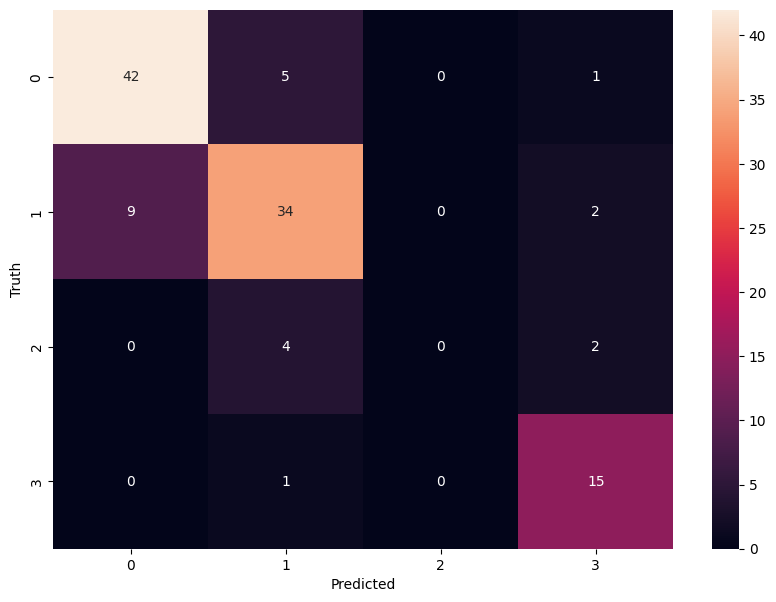

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_value, best_clf.predict(X_test_value))
print(cm)
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Save Trained Model

In [40]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'new_model.pkl') 

['new_model.pkl']

In [41]:
import joblib
# load model
savedModel=joblib.load('new_model.pkl')
savedModel

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma='auto', probability=True))])

[160.09586334228516, 931.2278747558594, 122.20446825027466, 585.805606842041] 0.9999220371246338


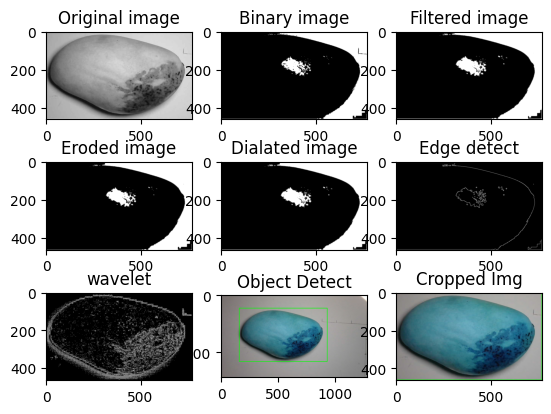

[46.879710763692856, 134.41595256328583, 92.51849949359894, 247.864830493927] 0.9479808807373047


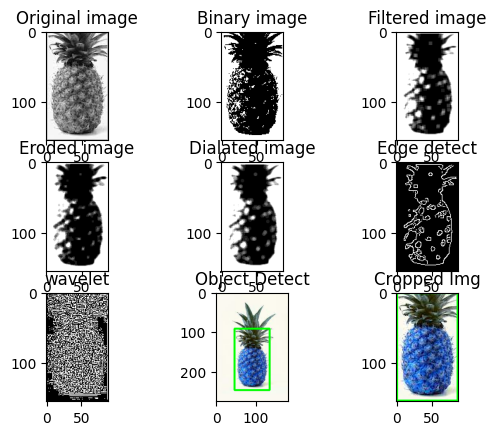

[48.33954870700836, 208.82170379161835, 40.06060838699341, 195.62431156635284] 0.9999067783355713


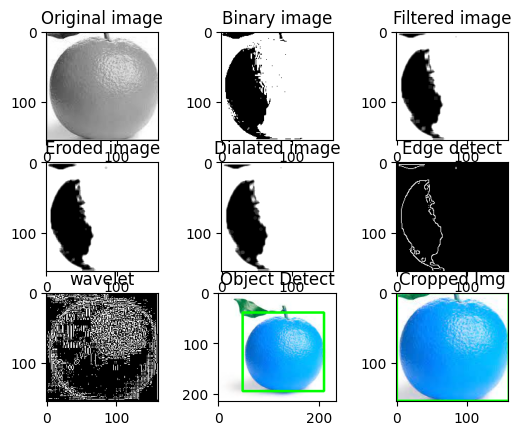

[53.685129433870316, 246.38164937496185, 15.231475174427032, 160.20747274160385] 0.9936477541923523


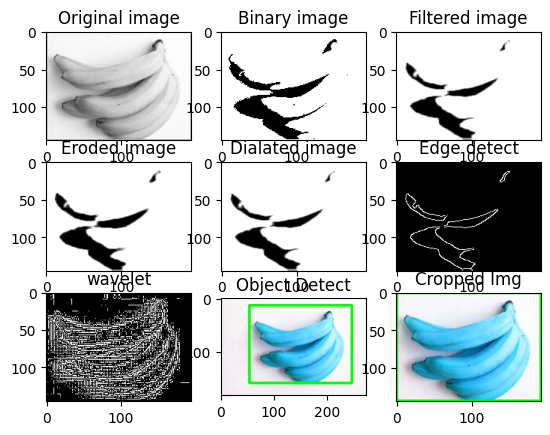

[42.36751228570938, 158.89682173728943, 9.045342534780502, 109.53903818130493] 0.9999353885650635


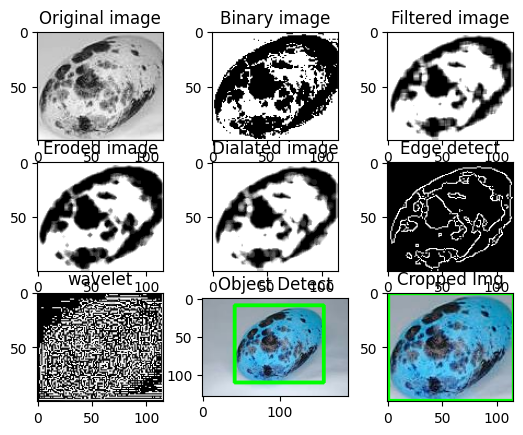

[175.06255853176117, 522.3018794059753, 169.44233179092407, 386.69232416152954] 0.9992724061012268


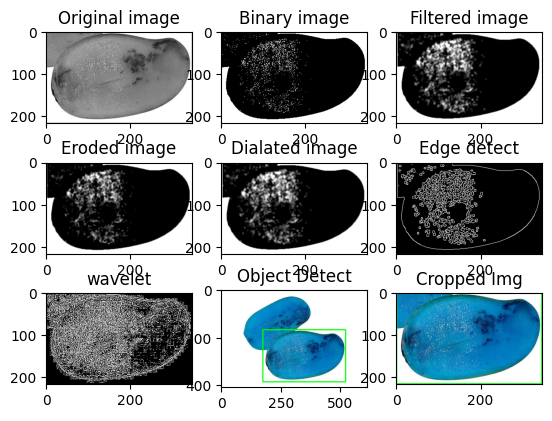

[4.659900069236755, 145.1165735721588, 9.45244386792183, 90.03331768512726] 0.9232580065727234


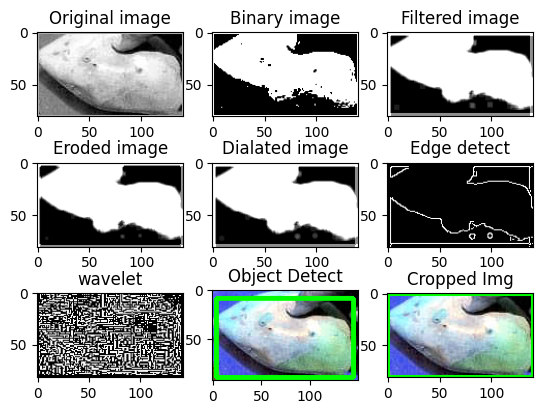

array([[0.02498543, 0.09884766, 0.64711171, 0.2290552 ],
       [0.07918967, 0.0715756 , 0.06050292, 0.78873182],
       [0.12324962, 0.07602184, 0.06692901, 0.73379952],
       [0.09215007, 0.07042701, 0.06480552, 0.7726174 ],
       [0.065627  , 0.07006652, 0.05564695, 0.80865953],
       [0.10961126, 0.08787661, 0.06452766, 0.73798446],
       [0.07756809, 0.067717  , 0.05885784, 0.79585708]])

In [46]:
find_path = r"Dataset/Grading_dataset/Extra_Class/Other"
images_to_find = os.listdir(find_path)

n =7
details = []
data = []
for img_file in images_to_find[:n]:
    path = os.path.join(find_path , img_file)
    image = cv2.imread(path)
    quality, ripeness, size = image_analysis(image)
    details.append([ size])
    crop_img = cropped_image(image)
    data.append(image_to_array(crop_img) /255)

#data =  [v/255 for v in data]
to_find_grade_img = np.array(data).reshape(len(data), -1)

h2 =savedModel.predict_proba(to_find_grade_img)
h2

In [47]:
df = pd.DataFrame(h2 * 100, columns =['Grade I','Grade II','Grade III','Defect'])
grd = df.idxmax(axis=1)
val = df.max(axis=1)
df = pd.concat([df,val,grd,pd.DataFrame(details)],axis=1)
df.columns = ['Grade I %','Grade II %','Grade III %','Defect %',"Grade Percent","Quality",  "Size"]
df 

,Grade I %,Grade II %,Grade III %,Defect %,Grade Percent,Quality,Size
0,2.498543,9.884766,64.711171,22.905520,64.711171,Grade III,Large
1,7.918967,7.157560,6.050292,78.873182,78.873182,Defect,small
2,12.324962,7.602184,6.692901,73.379952,73.379952,Defect,small
3,9.215007,7.042701,6.480552,77.261740,77.261740,Defect,small
4,6.562700,7.006652,5.564695,80.865953,80.865953,Defect,small
5,10.961126,8.787661,6.452766,73.798446,73.798446,Defect,medium
6,7.756809,6.771700,5.885784,79.585708,79.585708,Defect,small
